In [1]:
import pandas as pd
import numpy as np
import os
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils
import vtk
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import time
from tqdm import tqdm

In [2]:
# setup the mesh meta to handle downloads and caching
mesh_dir = 'data/cell_meshes' # or change to your desired folder
seg_source = 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public' # static: "precomputed://gs://iarpa_microns/minnie/minnie65/seg"
mm = trimesh_io.MeshMeta(cv_path=seg_source,
                         disk_cache_path=mesh_dir, 
                         cache_size=20)

In [3]:
cell_id_list = [864691135397985569, 
                864691134965433631, 864691135100839712, 864691135210965952, 864691135446178450, 
                864691135479068358, 864691135590803467, 864691135718708273, 864691135876855379, 
                864691136274045374, 864691136311785021, 864691136389425783, 864691136617703131]

# Chandelier 864691134965433631 with neurons with 4 or more syanpses from Chand

#[864691135105583693, 864691136175611654, 864691135341563589, 864691136100760693, 864691136195001420, 864691135517281235, 864691135505383154]
# Chandelier with top 6 targets that have 4 or more synapses

#[864691135349628119, 864691136228111441]
#[864691135763235638, 864691136194966604]
#[864691136275359757, 864691135135661593] # testing a possible chandelier cell and one connection; this does not appear to be a chand

#[864691135349628119, 864691135616427625, 864691136228111441, 864691135338802662, 864691136663195614, 864691134918592778, 864691135701642875, 864691135118535901, 864691135349240279, 864691135782690611, 864691135464143934, 864691136912632561, 864691136176241414, 864691136740782428, 864691136602771153, 864691135491764575, 864691135856964654, 864691135915877734, 864691135472997682, 864691136091546036, 864691135082183671, 864691135974785903, 864691136578577428, 864691135995464618, 864691136194253526, 864691136040989782, 864691135257245615, 864691135800991586, 864691135684283122, 864691135755487186, 864691136175055110, 864691135475565888, 864691136238282044, 864691136952201183, 864691135397533473, 864691135463417406, 864691135211205824, 864691135645672943, 864691135278202785, 864691135571226661, 864691135687864032, 864691135156418916, 864691136904446130, 864691136238226492]
# Chandelier cell 864691135349628119 in position 0
# 43 neurons that receive 4 or more synapses from Chandelier 864691135349628119 


In [4]:
# make a dictionary to hold the mesh file for each cell id in the list

mesh_dictionary = {}
for i in range(len(cell_id_list)):
    mesh_file = os.path.join(mesh_dir, str(cell_id_list[i]) + '.h5') # '_0' + '.h5')
    mesh_dictionary['cell_' + str(i)] = mm.mesh(filename = mesh_file)

In [5]:
mesh_dictionary

{'cell_0': <trimesh.Mesh(vertices.shape=(1455855, 3), faces.shape=(2932771, 3))>,
 'cell_1': <trimesh.Mesh(vertices.shape=(3851872, 3), faces.shape=(7724167, 3))>,
 'cell_2': <trimesh.Mesh(vertices.shape=(3241566, 3), faces.shape=(6498859, 3))>,
 'cell_3': <trimesh.Mesh(vertices.shape=(2571395, 3), faces.shape=(5151342, 3))>,
 'cell_4': <trimesh.Mesh(vertices.shape=(3443196, 3), faces.shape=(6908903, 3))>,
 'cell_5': <trimesh.Mesh(vertices.shape=(3146934, 3), faces.shape=(6323955, 3))>,
 'cell_6': <trimesh.Mesh(vertices.shape=(3252678, 3), faces.shape=(6520943, 3))>,
 'cell_7': <trimesh.Mesh(vertices.shape=(3840780, 3), faces.shape=(7707549, 3))>,
 'cell_8': <trimesh.Mesh(vertices.shape=(2062672, 3), faces.shape=(4141188, 3))>,
 'cell_9': <trimesh.Mesh(vertices.shape=(3160400, 3), faces.shape=(6338974, 3))>,
 'cell_10': <trimesh.Mesh(vertices.shape=(2191646, 3), faces.shape=(4397423, 3))>,
 'cell_11': <trimesh.Mesh(vertices.shape=(3621420, 3), faces.shape=(7235569, 3))>,
 'cell_12': <t

### Import synapse table

In [6]:
table_path = 'data/synapse_tables/'

In [7]:
# set scale factor for applying conversion for pixel position of synapses
scale_factor = [4,4,40]

In [8]:
# open post-synaptic sites on the Chandelier cell in index 0

post_table = pd.read_csv(f'{table_path}{cell_id_list[0]}_syn_df_post.csv')
print(f"length: {len(post_table)}")
post_table.head()

length: 4555


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,405121119,2020-11-04 06:48:59.036865+00:00,NaN,t,13496,109356671188892750,864691135706697056,109356671188882080,864691135397985569,[324482 87798 19955],[324532 87902 19950],[324478 87826 19945]
1,416857574,2020-11-04 06:48:59.403833+00:00,NaN,t,8684,110552458870595995,864691136524105981,110552458870594810,864691135397985569,[333094 84276 20381],[332946 84322 20376],[332959 84214 20383]
2,416432843,2020-11-04 06:48:59.326085+00:00,NaN,t,5228,110696632198451368,864691134990697805,110696632198451550,864691135397985569,[334108 110136 19197],[334026 110204 19202],[334106 110182 19205]
3,389474611,2020-11-04 06:49:11.886757+00:00,NaN,t,2164,108090239951826046,864691135467990980,108090239951828332,864691135397985569,[315214 89600 19683],[315354 89580 19688],[315262 89568 19683]
4,403289856,2020-11-04 06:49:11.886757+00:00,NaN,t,1276,109288639040671287,864691135463229380,109288707760140610,864691135397985569,[323834 105650 20527],[323758 105720 20519],[323783 105650 20523]


In [9]:
chand_postsyn_position_array = post_table.ctr_pt_position.values
chand_postsyn_position_array

array(['[324478  87826  19945]', '[332959  84214  20383]',
       '[334106 110182  19205]', ..., '[319366  97322  20049]',
       '[318682 111620  20192]', '[325345 104598  20446]'], dtype=object)

In [10]:
# Format the array with commas between values and convert to a numeric array
chand_postsyn_formatted_array = np.array([np.fromstring(item.strip('[]'), sep=' ') for item in chand_postsyn_position_array])

# Apply the scale factor transformation
chand_postsyn_transformed_array = chand_postsyn_formatted_array * scale_factor

# Convert the transformed array to integers
postsyn_xyz = chand_postsyn_transformed_array.astype(int)
postsyn_xyz

array([[1297912,  351304,  797800],
       [1331836,  336856,  815320],
       [1336424,  440728,  768200],
       ...,
       [1277464,  389288,  801960],
       [1274728,  446480,  807680],
       [1301380,  418392,  817840]])

In [11]:
# open pre-synaptic/output synapse table of index 0 in cell_id_list (the Chandelier cell)

pre_table = pd.read_csv(f'{table_path}{cell_id_list[0]}_syn_df_pre.csv')
print(f"length: {len(pre_table)}")
pre_table.head()

length: 301


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,404931405,2020-11-04 06:48:59.326085+00:00,NaN,t,6100,109432675198581331,864691135397985569,109432675198577279,864691135511460560,[324992 129858 21963],[325058 129906 21954],[325038 129840 21959]
1,382604970,2020-11-04 06:48:59.510128+00:00,NaN,t,1636,107528732973313968,864691135397985569,107528732973337107,864691135865543557,[311194 100304 18745],[311088 100312 18756],[311136 100264 18750]
2,403854339,2020-11-04 06:49:11.545614+00:00,NaN,t,2084,109499607767656143,864691135397985569,109499607767655080,864691135481716357,[325486 104284 20437],[325566 104294 20436],[325540 104276 20435]
3,385002847,2020-11-04 06:49:11.545614+00:00,NaN,t,2468,107672493984493151,864691135397985569,107672493984497832,864691135538970738,[311892 122598 17768],[311928 122674 17770],[311908 122628 17770]
4,427032923,2020-11-04 06:53:24.912290+00:00,NaN,t,12712,111333249632055074,864691135397985569,111333318351529892,864691135988011011,[338954 134836 20576],[338950 134858 20567],[338968 134860 20569]


In [12]:
print(f"length: {len(pre_table['post_pt_root_id'].unique())}")
# print(pre_table['post_pt_root_id'].unique())

length: 191


## Display

In [13]:
# increase output window size for plotly

from IPython.core.display import display, HTML

# Adjust the size of the output cell
display(HTML('''
<style>
    .output_wrapper, .output {
        height: auto !important;
        max-height: none !important;
    }
    .output_scroll {
        height: auto !important;
        max-height: none !important;
    }
</style>
'''))


### Set up Chandelier-target pair

In [14]:
post_index = 1 # set the starting index following the Chandelier cell at index 0; 1 by default

# Chandelier cell body and post-synaptic sites
chand = mesh_dictionary['cell_0']

# Plot target neuron and synapses recieved from the Chandelier cell
target = mesh_dictionary['cell_' + str(post_index)]

# retrieve and plot location of synaptic sites received from Chandelier cell
target_syn_position_array = pre_table[pre_table['post_pt_root_id'] == cell_id_list[post_index]].ctr_pt_position.values
# Format the array with commas between values and convert to a numeric array
target_formatted_array = np.array([np.fromstring(item.strip('[]'), sep=' ') for item in target_syn_position_array])
# Apply the scale factor transformation
target_transformed_array = target_formatted_array * scale_factor
# Convert the transformed array to integers
presyn_xyz = target_transformed_array.astype(int)


In [15]:
print(f'Chandelier root id: {cell_id_list[0]}')
print(f'Target root id: {cell_id_list[post_index]}')

Chandelier root id: 864691135397985569
Target root id: 864691134965433631


In [16]:
target_syn_position_array

array(['[332837 111629  23063]', '[332512 113554  23052]',
       '[333188 110800  23075]', '[332674 112893  23043]'], dtype=object)

In [17]:
pre_table

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,404931405,2020-11-04 06:48:59.326085+00:00,NaN,t,6100,109432675198581331,864691135397985569,109432675198577279,864691135511460560,[324992 129858 21963],[325058 129906 21954],[325038 129840 21959]
1,382604970,2020-11-04 06:48:59.510128+00:00,NaN,t,1636,107528732973313968,864691135397985569,107528732973337107,864691135865543557,[311194 100304 18745],[311088 100312 18756],[311136 100264 18750]
2,403854339,2020-11-04 06:49:11.545614+00:00,NaN,t,2084,109499607767656143,864691135397985569,109499607767655080,864691135481716357,[325486 104284 20437],[325566 104294 20436],[325540 104276 20435]
3,385002847,2020-11-04 06:49:11.545614+00:00,NaN,t,2468,107672493984493151,864691135397985569,107672493984497832,864691135538970738,[311892 122598 17768],[311928 122674 17770],[311908 122628 17770]
4,427032923,2020-11-04 06:53:24.912290+00:00,NaN,t,12712,111333249632055074,864691135397985569,111333318351529892,864691135988011011,[338954 134836 20576],[338950 134858 20567],[338968 134860 20569]
...,...,...,...,...,...,...,...,...,...,...,...,...
296,377268073,2020-11-04 12:56:48.427507+00:00,NaN,t,812,107391362605249779,864691135397985569,107391362605237257,864691135987883779,[310110 125424 17855],[310118 125522 17848],[310121 125435 17852]
297,409842791,2020-11-04 11:30:17.062704+00:00,NaN,t,1720,109924294334892937,864691135397985569,109924294334887109,864691135816354383,[328580 122846 21704],[328492 122854 21700],[328554 122832 21703]
298,416257444,2020-11-04 07:03:22.546382+00:00,NaN,t,1080,110275451062487007,864691135397985569,110275451062494890,864691135382949338,[331200 117704 23384],[331166 117676 23393],[331176 117635 23386]
299,390991997,2020-11-04 09:30:49.223739+00:00,NaN,t,896,108095050382115119,864691135397985569,108095050382075089,864691136812291955,[314938 125540 19990],[315068 125486 19974],[315024 125540 19983]


### 2D matplotlib scatterplot

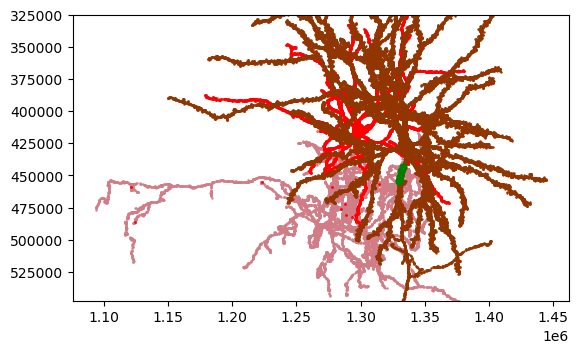

In [18]:
cell_gran = 50
cell_opac = 1

fig, ax = plt.subplots()

# plot cell body at defined granularity
ax.scatter(
    chand.vertices[::cell_gran, 0],
    chand.vertices[::cell_gran, 1],
    s=0.5, 
    alpha=cell_opac, 
    color=np.random.rand(3,)
)

# all post-synaptic (input or incoming) sites on the Chandelier cell
# comment or uncomment to hide or show
ax.scatter(postsyn_xyz[:,0], postsyn_xyz[:,1], c='red', s=1, alpha=1) # modify c, s, and alpha if desired

# set aspect and y-scale
ax.set_aspect('equal')
ax.set_ylim(np.max(chand.vertices[:,1]), np.min(chand.vertices[:,1]))

# plot target cell body
ax.scatter(
    target.vertices[::cell_gran, 0],
    target.vertices[::cell_gran, 1],
    s=0.5, 
    alpha=cell_opac, 
    color=np.random.rand(3,)
)

# plot target synapse positions
ax.scatter(presyn_xyz[:,0], presyn_xyz[:,1], c='green', s=25, alpha=1) # modify c, s, and alpha if desired

# set aspect and y-scale
# ax.set_aspect('equal')
# ax.set_ylim(np.max(target.vertices[:,1]), np.min(target.vertices[:,1]))

plt.show()

### 3D interactive plotly scatterplot

In [19]:
# use same settings as previous 2d plot
# cell_gran = 5000
# cell_opac = 1
chand_color = 'rgb(0.5, 0.5, 0.5)'

fig = go.Figure()

# plot Chandelier cell body
fig.add_trace(go.Scatter3d(
    x=chand.vertices[::cell_gran, 0],
    y=chand.vertices[::cell_gran, 1],
    z=chand.vertices[::cell_gran, 2],
    mode='markers',
    marker=dict(size=0.5, opacity=cell_opac, color=chand_color), #'rgb({}, {}, {})'.format(*np.random.rand(3,))),
    hoverinfo='none',
    showlegend=False
))

# uncomment to add Chandelier post-synaptic (incoming/input) sites

fig.add_trace(go.Scatter3d(
    x=postsyn_xyz[:, 0],
    y=postsyn_xyz[:, 1],
    z=postsyn_xyz[:, 2],
    mode='markers',
    marker=dict(
        color='red',      # Marker color
        size=1,           # Marker size
        opacity=0.75         # Transparency
    ),
    hoverinfo='none',
    showlegend=False
))

# plot target cell body
fig.add_trace(go.Scatter3d(
    x=target.vertices[::cell_gran, 0],
    y=target.vertices[::cell_gran, 1],
    z=target.vertices[::cell_gran, 2],
    mode='markers',
    marker=dict(size=0.5, opacity=cell_opac, color='rgb({}, {}, {})'.format(*np.random.rand(3,))),
    hoverinfo='none',
    showlegend=False
))

# add target synaptic sites received from Chandelier cell
fig.add_trace(go.Scatter3d(
    x=presyn_xyz[:, 0],
    y=presyn_xyz[:, 1],
    z=presyn_xyz[:, 2],
    mode='markers',
    marker=dict(
        color='green',      # Marker color
        size=10,           # Marker size
        opacity=0.5         # Transparency
    ),
    hoverinfo='none',
    showlegend=False
))

# Set the camera view
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0, z=1)  # Adjust these values to match the view in your screenshot
)

fig.update_layout(
    width=1000,
    height=1000,
    scene=dict(
        xaxis=dict(autorange='reversed'),  # Reverse the x-axis
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.4),  # Compress the z-axis
        camera=camera
    ),
     dragmode='orbit'  # Set default interaction mode to orbital rotation
)

# Customize layout to suppress axes, labels, and background shading
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),  # Hide x-axis
        yaxis=dict(visible=False),  # Hide y-axis
        zaxis=dict(visible=False),  # Hide z-axis
        bgcolor='rgba(0,0,0,0)'     # Set background to transparent
    )
)

fig.show()

### vtk OpenGL visualizer

In [20]:
# opacity and color settings for cell membrane meshes 
chand_opac = 0.4
chand_color = (0.2, 0.4, 0.7)
target_opac = 0.4

# settings to visualize pre and post synaptic sites (as dots)
pre_color = (0.2, 0.9, 0.2)
post_color = (0.9, 0.2, 0.2)
pre_opac = 0.5
post_opac = 1
pre_size = 2000 #250
post_size = 250 #250
presyn_actor = trimesh_vtk.point_cloud_actor(presyn_xyz, size=pre_size, opacity=pre_opac, color=pre_color)  
postsyn_actor = trimesh_vtk.point_cloud_actor(postsyn_xyz, size=post_size, opacity=post_opac, color=post_color)

# add Chandelier cell and target cell membrane meshes
mesh_actor = {}
mesh_actor['cell_0'] = trimesh_vtk.mesh_actor(chand, opacity=chand_opac, color=chand_color)
mesh_actor['cell_' + str(post_index)] = trimesh_vtk.mesh_actor(target, opacity=target_opac, color=np.random.random(size=3))
locals().update(mesh_actor)

# add Chandelier input synapses and pre-synaptic contact to the target cell
mesh_actor['presyn_actor'] = presyn_actor
mesh_actor['postsyn_actor'] = postsyn_actor
locals().update(mesh_actor)

# calculate the centroid of the presyn_xyz coordinates to use as the center of the camera view
presyn_centroid = presyn_xyz.mean(axis=0)

#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(presyn_centroid, backoff=500)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors(mesh_actor.values(), camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x0000023FBB999B80) at 0x0000023FAC5E8CA8>

### save image to disk

In [21]:
# define subdirectory to save vtk images
chand_folder_name = f'chandelier/chand_{cell_id_list[0]}'

# Create the subdirectory
#os.makedirs(chand_folder_name, exist_ok=True)

# create filename
pair_filename = f'chandelier/chand_{cell_id_list[0]}/chand_{cell_id_list[0]}_target_{cell_id_list[post_index]}.png'

# uncomment to save

# #camera = trimesh_vtk.oriented_camera(presyn_centroid, backoff=500) # modify backoff accordingly
# trimesh_vtk.render_actors(mesh_actor.values(),
#                           filename=pair_filename,
#                           do_save=True,
#                           scale=4,
#                           camera=camera
#                          )

In [22]:
movie_filename = f'chand_{cell_id_list[0]}_target_{cell_id_list[post_index]}_movie_zoom'
movie_filename

'chand_864691135397985569_target_864691134965433631_movie_zoom'

In [23]:
# # vtk animation code here

# camera_1 = trimesh_vtk.oriented_camera(mesh_actor.centroid, backoff=500)
# camera_2 = trimesh_vtk.oriented_camera(mesh_actor.centroid, backoff=100)
# movie_filename = f'chand_{cell_id_list[0]}_target_{cell_id_list[post_index]}_movie_zoom'

# trimesh_vtk.render_movie([mesh_actor],
#                          movie_filename,
#                          [0,300],
#                          [camera_1, camera_2],
#                          do_save=True)

In [24]:
# # save movie as mp4 using moviepy
# import moviepy.editor as mpe

# clip = mpe.ImageSequenceClip(movie_filename,fps=30)
# clip.write_videofile(f'{movie_filename}.mp4')

### Generate vtk visualizations of all Chandelier-target pairs

In [25]:
# Create subdirectory to save vtk images
chand_folder_name = f'chandelier/chand_{cell_id_list[0]}'
os.makedirs(chand_folder_name, exist_ok=True)

# Opacity and color settings for cell membrane meshes
chand_opac = 0.4
chand_color = (0.2, 0.4, 0.7)
target_opac = 0.4

# Settings to visualize pre and post synaptic sites (as dots)
pre_color = (0.2, 0.9, 0.2)
post_color = (0.9, 0.2, 0.2)
pre_opac = 0.5
post_opac = 1
pre_size = 2000
post_size = 250

# Chandelier cell body and post-synaptic sites
chand = mesh_dictionary['cell_0']

# Iterate over the target cells in mesh_dictionary
for post_index in range(1, len(mesh_dictionary)):
    # Plot target neuron and synapses received from the Chandelier cell
    target = mesh_dictionary['cell_' + str(post_index)]

    # Retrieve and plot location of synaptic sites received from Chandelier cell
    target_syn_position_array = pre_table[pre_table['post_pt_root_id'] == cell_id_list[post_index]].ctr_pt_position.values
    # Format the array with commas between values and convert to a numeric array
    target_formatted_array = np.array([np.fromstring(item.strip('[]'), sep=' ') for item in target_syn_position_array])
    # Apply the scale factor transformation
    target_transformed_array = target_formatted_array * scale_factor
    # Convert the transformed array to integers
    presyn_xyz = target_transformed_array.astype(int)

    # Create presynaptic and postsynaptic actors
    presyn_actor = trimesh_vtk.point_cloud_actor(presyn_xyz, size=pre_size, opacity=pre_opac, color=pre_color)  
    postsyn_actor = trimesh_vtk.point_cloud_actor(postsyn_xyz, size=post_size, opacity=post_opac, color=post_color)

    # Add Chandelier cell and target cell membrane meshes
    mesh_actor = {}
    mesh_actor['cell_0'] = trimesh_vtk.mesh_actor(chand, opacity=chand_opac, color=chand_color)
    mesh_actor['cell_' + str(post_index)] = trimesh_vtk.mesh_actor(target, opacity=target_opac, color=np.random.random(size=3))
    locals().update(mesh_actor)

    # Add Chandelier input synapses and presynaptic contact to the target cell
    mesh_actor['presyn_actor'] = presyn_actor
    mesh_actor['postsyn_actor'] = postsyn_actor
    locals().update(mesh_actor)

    # Calculate the centroid of the presyn_xyz coordinates to use as the center of the camera view
    presyn_centroid = presyn_xyz.mean(axis=0)

    # Create a camera object and define the view
    camera = trimesh_vtk.oriented_camera(presyn_centroid, backoff=500)

    # Render the actors and open a pop-up Python window
    trimesh_vtk.render_actors(mesh_actor.values(), camera=camera)

    # Create filename
    pair_filename = f'chandelier/chand_{cell_id_list[0]}/chand_{cell_id_list[0]}_target_{cell_id_list[post_index]}.png'

    # Save to disk
    trimesh_vtk.render_actors(
        mesh_actor.values(),
        filename=pair_filename,
        do_save=True,
        scale=4,
        camera=camera
    )


In [26]:
cell_id_list[post_index]

864691134965433631